<a href="https://colab.research.google.com/github/kamalova/Rice_Leaf_Disease_Img_Classification_DL/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Rice Leaf Disease Image Classification Using Deep Learning** 

**Author : Nurgul Kurbanali kyzy**

### Business Case

Rice is one of the most cultivated crops in the world, in over a hundred countries. Rice production is the 3rd largest among cereals in the U.S. Arkansas where our stakeholders from ranks 1st in rice production in the U.S., accounting for over 40% of rice production.With rice being such a valuable commodity, a common problem that widespread cultivators face is infestation of rice leaf diseases. Infection by diseases results in great loss to economic to the farmers in every year.

In traditional practices, identification is 
performed either by visual observation or by testing in laboratory. The visual observation requires expertise and it may vary subject 
to an individual which may lead to an error while the laboratory test is time consuming and may not be able to provide the results in 
time. Taking into consideration the large range of possible diseases, it becomes a difficult task for cultivators to individually identify 
these cases, especially for large fields. 

In an effort to solve this problem and assist farmers and everyday gardeners to ensure a healthy crop, *Leaf Green* uses an image classification model to help predict and identify two common leaf diseases *(Brown Spot, Leaf Blast)* along with *Healthy* plants based on 3355 rice images.




💻 Project Notebook was run in **Google Colab**

#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from matplotlib.transforms import offset_copy
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow import keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Flatten,Conv2D,MaxPooling2D
from keras.layers import   Activation, BatchNormalization                                        
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import itertools 
import zipfile
from PIL import Image
import warnings
warnings.filterwarnings('ignore') #ignores warnings
import os
from pathlib import Path
# Libraris for uploding dataset from the Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Libraries  for splitting the img folder into(train,val,test)
!pip install split-folders
import splitfolders

# Remove unnecessary folder in colab
import shutil
shutil.rmtree('/content/sample_data')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Load Dataset and Split into Subsets

In [ ]:
# Upload dataset from Kaggle
!kaggle datasets download -d nizorogbezuode/rice-leaf-images

 96% 17.0M/17.7M [00:01<00:00, 12.3MB/s]
100% 17.7M/17.7M [00:01<00:00, 13.4MB/s]


In [ ]:
# Unzip file
zip_ref = zipfile.ZipFile("/content/rice-leaf-images.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Walk through pizza_steak directory and list number of files
for dir_path, dir_names, file_names in os.walk("rice_images"):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in '{dir_path}'.")

There are 4 directories and 0 images in 'rice_images'.
There are 0 directories and 779 images in 'rice_images/_LeafBlast'.
There are 0 directories and 1488 images in 'rice_images/_Healthy'.
There are 0 directories and 523 images in 'rice_images/_BrownSpot'.
There are 0 directories and 565 images in 'rice_images/_Hispa'.


In [ ]:
# Removing underscore of the img folder names
os.rename('/content/rice_images/_BrownSpot', '/content/rice_images/BrownSpot')
os.rename('/content/rice_images/_Healthy', '//content/rice_images/Healthy')
os.rename('/content/rice_images/_Hispa', '/content/rice_images/Hispa')
os.rename('/content/rice_images/_LeafBlast', '/content/rice_images/LeafBlast')

In [ ]:
# Split dataset into train/validation/test sets
splitfolders.ratio("/content/rice_images", # The location of full dataset
                   output="dataset", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .1, .1), # The ratio of splited dataset
                   group_prefix=None, 
                   move=False )

Copying files: 3355 files [00:00, 9283.14 files/s]


### Data Exploration

The data was sourced from https://www.kaggle.com/datasets/nizorogbezuode/rice-leaf-images dataset . This is a dataset for classification of rice leaf diseases. The images are in 4 folders, classified as follows:

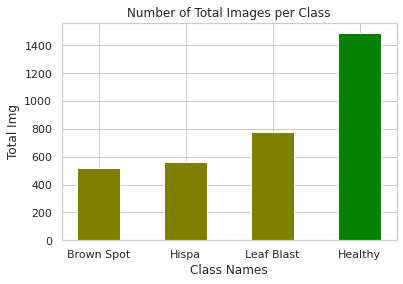

In [ ]:
#plot number of classes to identify possible imbalances
num_class = {'Brown Spot':523, 
                 'Hispa': 565,
                 'Leaf Blast': 779,
                 'Healthy': 1488}

plt.bar(num_class.keys(), num_class.values(), width = .5, color=['olive', 'olive', 'olive', 'green'])
plt.xlabel('Class Names')
plt.ylabel('Total Img')
plt.title("Number of Total Images per Class");

In [ ]:
# Set path to were dataset is saved 
train_dir = '/content/dataset/train/' 
val_dir = '/content/dataset/val/'
test_dir = "/content/dataset/test/"

# Set a path within train dataset to all classes
brownspot = [train_dir + '/BrownSpot/' + img for img in os.listdir(train_dir+ '/BrownSpot')[:6]]
healthy = [train_dir  + '/Healthy/' + img for img in os.listdir(train_dir + '/Healthy')[:6]]
hispa = [train_dir  + '/Hispa/' + img for img in os.listdir(train_dir + '/Hispa')[:6]]
leafblast = [train_dir  + '/LeafBlast/' + img for img in os.listdir(train_dir + '/LeafBlast')[:6]]

The following disease explanations are from the Rice Knowledge Bank, and more information can be found at http://www.knowledgebank.irri.org/

Natural green leaves indicate **healthy** rice plants.

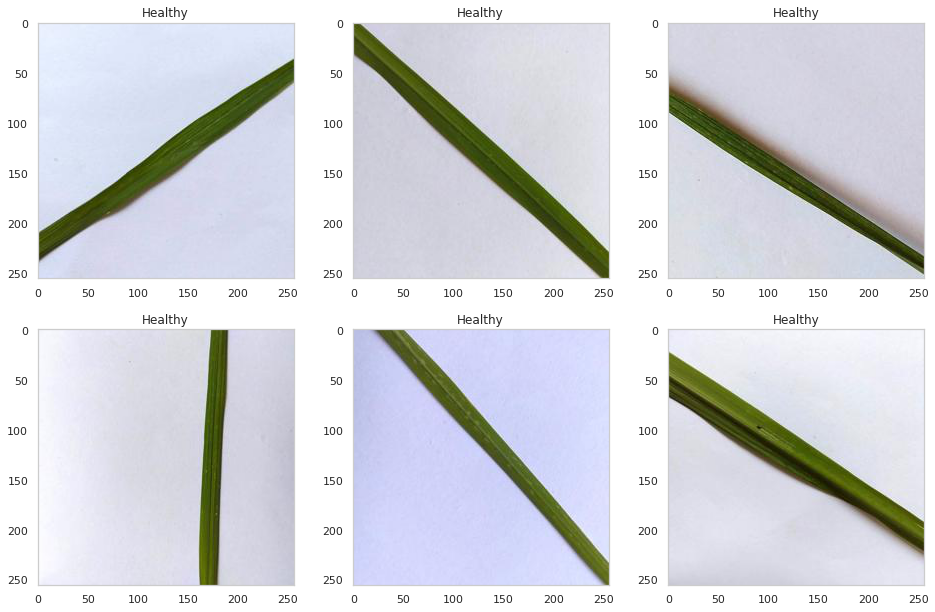

In [ ]:
# Plot samples from healthy class 
plt.figure(figsize=(16,16))
for i,k  in enumerate(healthy):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("Healthy")
    plt.grid(False);

Rice **Brown Spot**  is the one of the major fungal diseases in rice in which it is caused by *Bipolarisoryzae*. The fungus can survive in the seed for more than four years and can spread from plant to plant through air. This diseases mainly attacks the crop from seedling stage to milky stage. Brown spot is otherwise called as sesame leaf spot or *Helminthosporiose*. 
Brown spot causes both quality and quantity losses. 


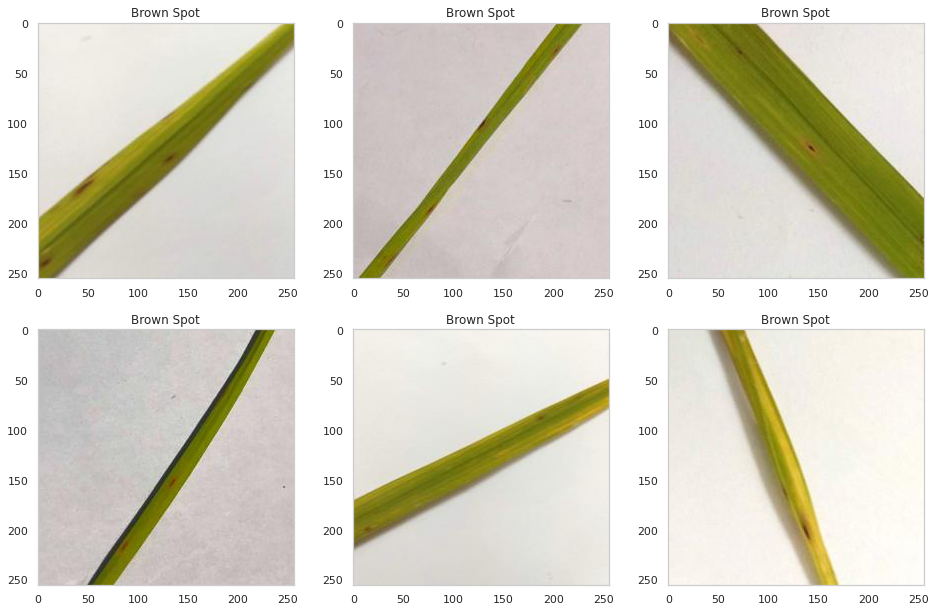

In [ ]:
# Plot sapmles from brown spot class 
plt.figure(figsize=(16,16))
for i,k  in enumerate(brownspot):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("Brown Spot")
    plt.grid(False);

Rice **Hispa** scrapes the upper surface of leaf blades leaving only the lower epidermis.It also tunnels through the leaf tissues. When damage is severe, plants become less vigorous. The presence of grassy weeds in and near rice fields as alternate hosts harbor and encourage the pest to develop. Heavily fertilized field also encourages the damage. 

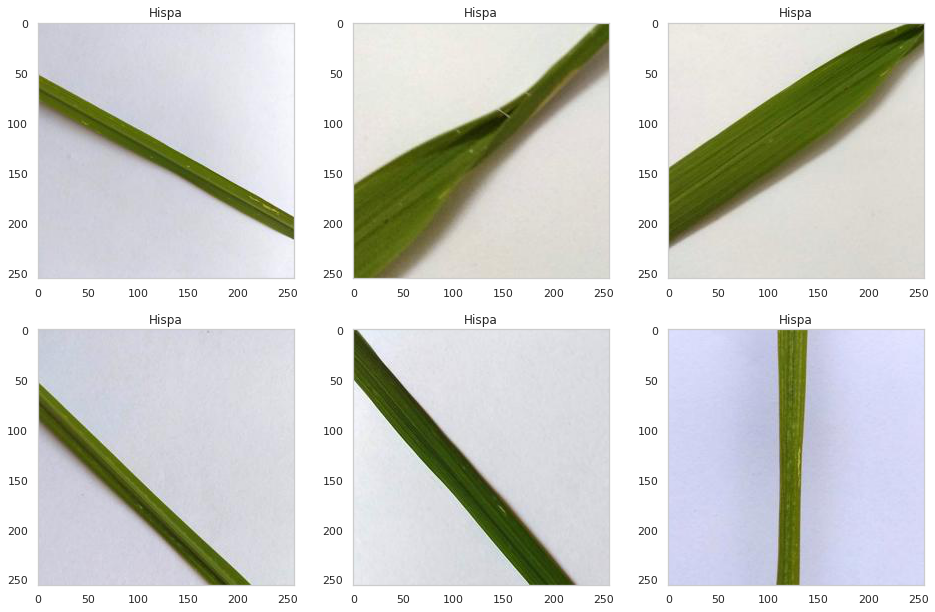

In [ ]:
# Plot sapmles from hispa class 
plt.figure(figsize=(16,16))
for i,k  in enumerate(hispa):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("Hispa")
    plt.grid(False);

Rice **Blast(leaf and collar)** is caused by the fungus Magnaporthe oryzae. It can affect all above ground parts of a rice plant: leaf, collar, node, neck, parts of panicle, and sometimes leaf sheath. Rice can have blast in all growth stages. However, leaf blast incidence tends to lessen as plants mature and develop adult plant resistance to the disease. 

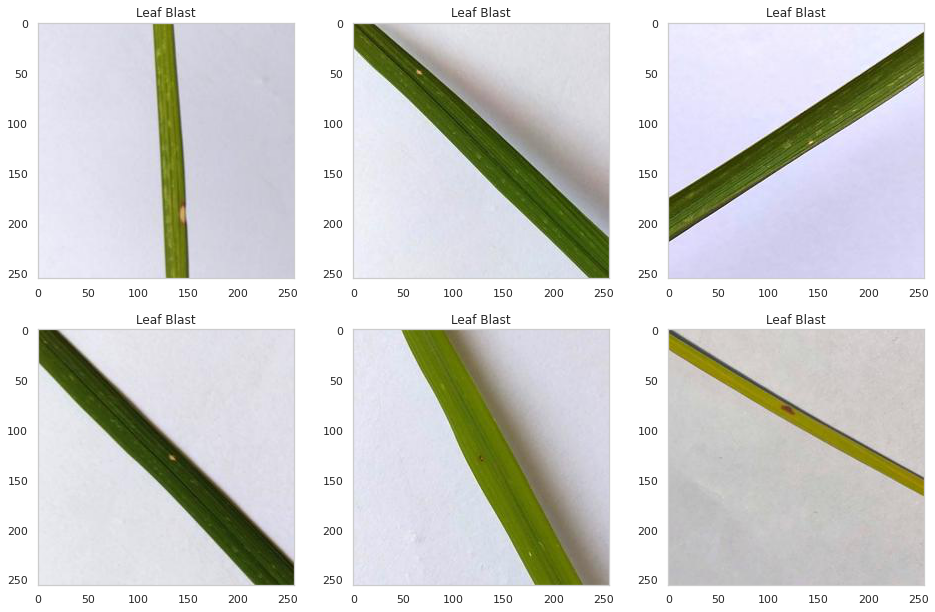

In [ ]:
# Plot sapmles from leaf blast class 
plt.figure(figsize=(16,16))
for i,k  in enumerate(leafblast):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("Leaf Blast")
    plt.grid(False)

In [ ]:
# Check  size of first images from 2 class 
im_1 = Image.open('/content/dataset/train/BrownSpot/shape 1 .jpg')
im_2 = Image.open('/content/dataset/train/Healthy/shape 1 .jpg')
arr_1 = np.array(im_1)
arr_2 =np.array(im_2)
print(arr_1.shape, arr_2.shape)

(256, 256, 3) (256, 256, 3)


These images are in JPEG format and have good resolution with a width and height of 256*256. The image background is also white so there is no need to apply any background subtraction method. 

In [ ]:
# Create data generators
# Creation of train set 
train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                             train_dir, 
                                             batch_size=32, 
                                             target_size=(224,224),                                           
                                             class_mode="categorical", # type of problem we're working on
                                             subset = "training",
                                             color_mode='rgb',
                                             seed=127)
# Creation of validation set 
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                             val_dir, 
                                             batch_size=32, 
                                             target_size=(224,224), 
                                             class_mode="categorical", # type of problem we're working on
                                             #subset = "validation",
                                             color_mode='rgb',                                           
                                             seed=127)
# Creation of test set                                                                                  
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                            test_dir, 
                                            batch_size=32, 
                                            target_size=(224,224), 
                                            class_mode="categorical", # type of problem we're working on
                                            color_mode='rgb',
                                            seed=127,
                                            shuffle=False)

Found 2683 images belonging to 4 classes.
Found 333 images belonging to 4 classes.
Found 339 images belonging to 4 classes.


### Model Building

#### #1. Baseline (dummy) Model 

In [ ]:
# Set random seed
INPUT_SHAPE = (224, 224, 3) # height, width, colour channels
LOSS_FN =tf.keras.losses.CategoricalCrossentropy()  #loss function for multi-class classification model 

# Create a model 
base_model = tf.keras.Sequential([
  Flatten(input_shape=INPUT_SHAPE), 
  Dense(100, activation='relu'), 
  Dense(50, activation='relu'),
  Dense(4, activation='softmax') # multi class activation output
])

# Compile the model
base_model.compile(loss=LOSS_FN,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 100)               15052900  
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 15,058,154
Trainable params: 15,058,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the baseline model with 15 epochs
history_baseline= base_model.fit(train_set,
                        epochs=15,
                        validation_data=val_set)                        

Epoch 1/15
21/21 [==============================] - 7s 293ms/step - loss: 37.8423 - accuracy: 0.3075 - val_loss: 35.5169 - val_accuracy: 0.1682
Epoch 2/15
21/21 [==============================] - 6s 279ms/step - loss: 19.9240 - accuracy: 0.2903 - val_loss: 9.7449 - val_accuracy: 0.3994
Epoch 3/15
21/21 [==============================] - 6s 276ms/step - loss: 7.0607 - accuracy: 0.3272 - val_loss: 3.0344 - val_accuracy: 0.2342
Epoch 4/15
21/21 [==============================] - 6s 276ms/step - loss: 3.5681 - accuracy: 0.3347 - val_loss: 5.0210 - val_accuracy: 0.2312
Epoch 5/15
21/21 [==============================] - 6s 271ms/step - loss: 5.5305 - accuracy: 0.3235 - val_loss: 5.7286 - val_accuracy: 0.4444
Epoch 6/15
21/21 [==============================] - 7s 323ms/step - loss: 8.2587 - accuracy: 0.3235 - val_loss: 4.8013 - val_accuracy: 0.1832
Epoch 7/15
21/21 [==============================] - 6s 272ms/step - loss: 4.8803 - accuracy: 0.3358 - val_loss: 2.1892 - val_accuracy: 0.2372
Epo

In [ ]:
# Plot the training and validation loss curves separately
def plot_learning_curves(history):
  """
  Returns loss curves for training and validation metrics separately.
  """ 
  epochs = range(len(history.history["loss"]))
  accuracy = history.history["accuracy"]
  val_accuracy = history.history['val_accuracy']
 
  # Plot accuracy curve
  plt.figure(figsize=(8,3.5))
  plt.plot(epochs, accuracy, label="training_acc", color="#000000" )
  plt.plot(epochs, val_accuracy, label="validation_acc", color="goldenrod", marker='o')
  plt.title("Accuracy over Epochs ")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend();

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Plot loss curve
  plt.figure(figsize=(8,3.5))
  plt.plot(epochs, loss, label="training_loss",  color="#000000")
  plt.plot(epochs, val_loss, label="validation_loss",color="goldenrod", marker='o')
  plt.title("Loss over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend();

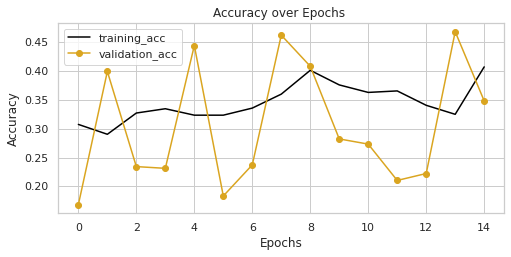

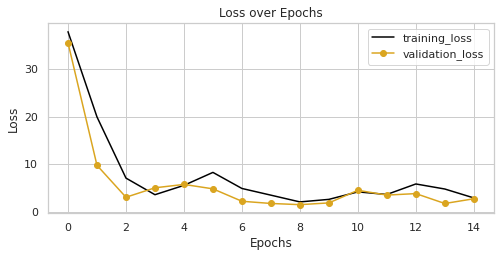

In [ ]:
plot_learning_curves(history_baseline)

Based on the learning curves of baseline model we can see a highly fluctuation of validation accuracy. But  validation loss going down - this makes sense.  After vanilla model we will try with CNN models 



CNN models have shown better performance in various applications including an agriculture. It consists of three layers, wherein the first layer is named as convolution layer, the second layer as pooling layer, and the last layer is so-called fully connected layer. The convolution and pooling layers are responsible for learning of the model and a fully connected layer does the classification.

#### #2. Model with Convolutional Neural Network (CNN3) 

In [ ]:
# Build first CNN model  with 3 convolutional layers
model_cnn1 = tf.keras.Sequential([
    Conv2D(filters=64,
           kernel_size=(3,3), 
           padding='same', # Add a zero padding to the feature map
           activation='relu',
           input_shape=INPUT_SHAPE), 
    MaxPooling2D(pool_size=(2,2)), # Added MaxPool
    Conv2D(filters=128, 
           kernel_size=(3,3),
           padding='same', 
           activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32,
           kernel_size=(3,3),
           activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.20),
    Flatten(),
    Dropout(0.20),
    Dense(4, activation='softmax') ])

# Compile the model
model_cnn1.compile(loss=LOSS_FN,
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["accuracy"])

# Fit the first CNN model 
history_cnn1 = model_cnn1.fit(train_set,
                        epochs=30,
                        steps_per_epoch= len(train_set),
                        validation_data=val_set)                    

Epoch 1/30
84/84 [==============================] - 18s 80ms/step - loss: 1.2880 - accuracy: 0.4406 - val_loss: 1.2096 - val_accuracy: 0.4595
Epoch 2/30
84/84 [==============================] - 7s 85ms/step - loss: 1.1779 - accuracy: 0.4939 - val_loss: 1.1602 - val_accuracy: 0.4925
Epoch 3/30
84/84 [==============================] - 5s 63ms/step - loss: 1.1162 - accuracy: 0.5136 - val_loss: 1.1579 - val_accuracy: 0.4985
Epoch 4/30
84/84 [==============================] - 5s 63ms/step - loss: 1.0860 - accuracy: 0.5240 - val_loss: 1.1217 - val_accuracy: 0.5285
Epoch 5/30
84/84 [==============================] - 5s 64ms/step - loss: 1.0773 - accuracy: 0.5289 - val_loss: 1.1196 - val_accuracy: 0.5015
Epoch 6/30
84/84 [==============================] - 5s 64ms/step - loss: 1.0283 - accuracy: 0.5628 - val_loss: 1.1134 - val_accuracy: 0.5315
Epoch 7/30
84/84 [==============================] - 5s 62ms/step - loss: 1.0091 - accuracy: 0.5598 - val_loss: 1.0925 - val_accuracy: 0.5375
Epoch 8/30
8

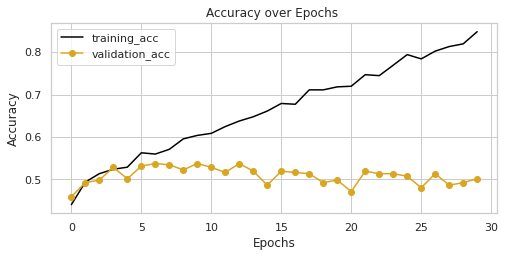

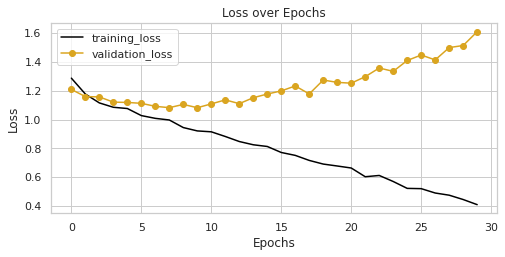

In [ ]:
plot_learning_curves(history_cnn1)

Despite of having a dropout layers in our first CNN model it is still suffering from overfitting. Thus we will try to combat overfitting by building with r and two conv layer and increasing the value of the dropout layes. In addition the optimizer will be changed to RMSprop from Adam that we used in our first CNN model.

#### #2. Model with  Convolutional Neural Network (CNN2) and RMSprop 

In [ ]:
# Build CNN2 with bigger dropout and RMSprop optimizer.
model_cnn2 = tf.keras.models.Sequential([
     Conv2D(filters=100,
           kernel_size=(3,3), 
           padding='same',
           activation='relu',
           input_shape=(INPUT_SHAPE)), 
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(filters=250, 
           kernel_size=(3,3),
           padding='same', 
           activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(4, activation='softmax') 
])

# Compile the model
model_cnn2.compile(loss=LOSS_FN,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=["accuracy"])

# Fit the  model 
history_cnn2 = model_cnn2.fit(train_set,
                         epochs=20,
                        validation_data=val_set )                     

Epoch 1/20
84/84 [==============================] - 12s 120ms/step - loss: 5.5095 - accuracy: 0.4137 - val_loss: 1.2314 - val_accuracy: 0.4625
Epoch 2/20
84/84 [==============================] - 9s 109ms/step - loss: 1.3641 - accuracy: 0.4562 - val_loss: 1.2429 - val_accuracy: 0.4805
Epoch 3/20
84/84 [==============================] - 9s 109ms/step - loss: 1.2693 - accuracy: 0.4741 - val_loss: 1.1550 - val_accuracy: 0.5045
Epoch 4/20
84/84 [==============================] - 9s 112ms/step - loss: 1.1490 - accuracy: 0.5076 - val_loss: 1.1389 - val_accuracy: 0.5105
Epoch 5/20
84/84 [==============================] - 9s 111ms/step - loss: 1.0456 - accuracy: 0.5643 - val_loss: 1.4689 - val_accuracy: 0.4625
Epoch 6/20
84/84 [==============================] - 9s 109ms/step - loss: 0.9759 - accuracy: 0.5874 - val_loss: 1.2067 - val_accuracy: 0.4865
Epoch 7/20
84/84 [==============================] - 9s 109ms/step - loss: 0.9074 - accuracy: 0.6221 - val_loss: 1.2048 - val_accuracy: 0.4865
Epoch

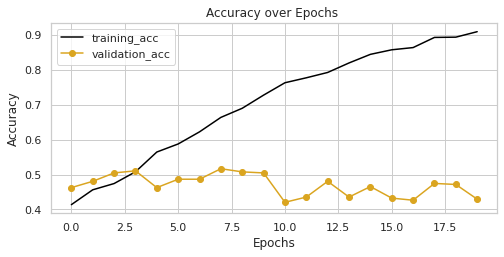

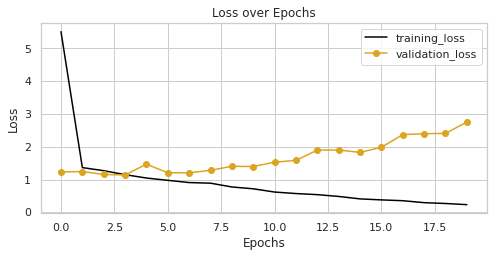

In [ ]:
plot_learning_curves(history_cnn2)

Our second CNN model still suffering from the overfitting and validation score did not get improved.
Mostly researchers found good results in implementing Batch Normalization after the activation layer. By adding Batch Normalization we reduce the internal covariate shift and instability in distributions of layer activations in deeper networks can reduce the effect of overfitting and works well with generalization data. So we  will use Batch Normalization as a *Regularization* technique in our third CNN model.

#### #3. Model with  Convolutional Neural Network (CNN3) and BatchNormalization

In [ ]:
# Build CNN3 along with BatchNormalization layer
model_cnn3 = Sequential([
    Conv2D(filters=64,
           kernel_size=(3,3), 
           padding='same', 
           activation='relu',
           input_shape=INPUT_SHAPE), 
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), 
    Conv2D(filters=64, 
           kernel_size=(3,3),
           padding='same', 
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32,
           kernel_size=(3,3),
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(4, activation='softmax') 
])

# Compile the model
model_cnn3.compile(loss=LOSS_FN,
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["accuracy"])

# Fit the first CNN model 
history_cnn3 = model_cnn3.fit(train_set,
                        epochs=25,
                        validation_data=val_set)

Epoch 1/25
84/84 [==============================] - 6s 67ms/step - loss: 1.7579 - accuracy: 0.4424 - val_loss: 1.3370 - val_accuracy: 0.4444
Epoch 2/25
84/84 [==============================] - 5s 61ms/step - loss: 1.2554 - accuracy: 0.5244 - val_loss: 1.2887 - val_accuracy: 0.4745
Epoch 3/25
84/84 [==============================] - 5s 63ms/step - loss: 1.1525 - accuracy: 0.5665 - val_loss: 1.4401 - val_accuracy: 0.3003
Epoch 4/25
84/84 [==============================] - 5s 63ms/step - loss: 0.9905 - accuracy: 0.6224 - val_loss: 1.6021 - val_accuracy: 0.1982
Epoch 5/25
84/84 [==============================] - 5s 64ms/step - loss: 0.8971 - accuracy: 0.6508 - val_loss: 1.4557 - val_accuracy: 0.3183
Epoch 6/25
84/84 [==============================] - 5s 62ms/step - loss: 0.7439 - accuracy: 0.7059 - val_loss: 1.4288 - val_accuracy: 0.3634
Epoch 7/25
84/84 [==============================] - 5s 63ms/step - loss: 0.6867 - accuracy: 0.7242 - val_loss: 1.5538 - val_accuracy: 0.4204
Epoch 8/25
84

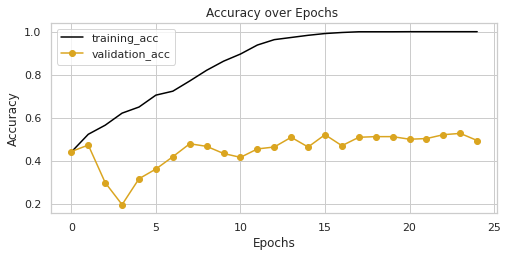

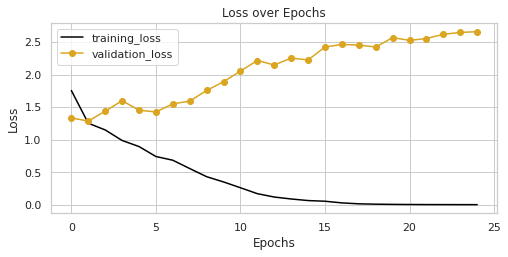

In [ ]:
plot_learning_curves(history_cnn3)

CNN  model with Batchnormalization fits too well to the training set. Model still  having a big difficulty with generalization. Our next approach to combat with an overfitting will be a *Data Augmentation* technique. It allows to us artificially increasing the amount of training data by generating new data points from existing data. It can help to improve the model prediction accuracy and reduce data overfitting

#### Data Augumentation

In [ ]:
# Create augmented data generator instance
train_aug_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range = (0.5,1.5),
                                   rotation_range=10, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15, 
                                   zoom_range=0.1,
                                   channel_shift_range = 10, 
                                   horizontal_flip=True,)
                                          
# Augment the whole train images
train_set_augmented = train_aug_datagen.flow_from_directory(train_dir,
                                                            color_mode='rgb',
                                                            subset='training',
                                                            target_size=(224,224),
                                                            batch_size=128,
                                                            shuffle = True,
                                                            class_mode='categorical')


Found 2683 images belonging to 4 classes.


Let's view few of the augmented images below

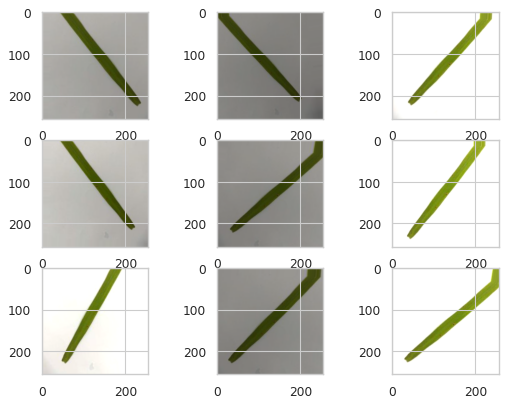

In [ ]:
# Brown Spot augmented images example
img_bs = load_img('/content/dataset/train/_BrownSpot/shape 100 .jpg')
data = img_to_array(img_bs)
samples = np.expand_dims(data, 0)
# Demonstrating random rotation
datagen = ImageDataGenerator(brightness_range = (0.5,1.5),
                                   rotation_range=10, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15, 
                                   zoom_range=0.1,
                                   channel_shift_range = 10, 
                                   horizontal_flip=True,
                             )
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
plt.figure(figsize=(8, 6), dpi=80)
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show();

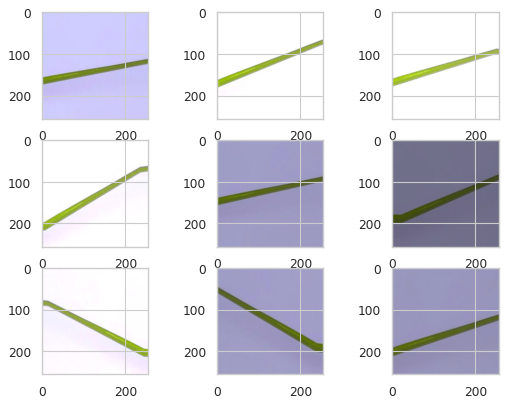

In [ ]:
# Hispa augmented images example
img_hispa = load_img("/content/dataset/train/_Hispa/shape 10 .jpg")
data = img_to_array(img_hispa)
samples = np.expand_dims(data, 0)
# Demonstrating random rotation
datagen = ImageDataGenerator(brightness_range = (0.5,1.5),
                                   rotation_range=10, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15, 
                                   zoom_range=0.1,
                                   channel_shift_range = 10, 
                                   horizontal_flip=True,
                             )
it = datagen.flow(samples, batch_size=1)
# Generate samples and plot
plt.figure(figsize=(8, 6), dpi=80)
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show();

he imbalanced dataset handling has some trade-offs such as whether the accuracy is high but prone to overfit or the accuracy is low with the loss also low. But our target is that we need higher accuracy and lower loss to get a generalized model.Thus, we try to  reuse of a pre-trained model on a our case. Namely we will use *Transfer learning*  design methodology which is an optimization, a shortcut to saving time or getting better performance. In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another. 

#### #4. Transfer Learning with *ResNet152v2* and *Data Augmentation*

ResNet (Residual Neural Network) was proposed in a 152-layer neural network, which won the
championship in the ILSVRC2015 competition. The key idea of ResNet is to add a direct connection
channel to the network, which retains a certain proportion of the output of the previous network layers.
That is, the neural network of this layer does not need to learn the entire output, but learns the residual
of the previous network output, so ResNet is also called the residual network. 


In [ ]:
# Create the base pre-trained ResNet152v2 model
base_resnet152v2=tf.keras.applications.ResNet152V2(pooling="avg", 
                                          weights="imagenet", 
                                          include_top=False, 
                                          input_shape=INPUT_SHAPE)

# Set the layers to frozen to keep the weights already made                                      
for layers in base_resnet152v2.layers:
            layers.trainable=False
# Add layers to model
last_output = base_resnet152v2.layers[-1].output
res151v2_x = Flatten()(last_output)
res151v2_x = Dense(128, activation = "relu")(res151v2_x)
res151v2_x = Dense(4, activation = "softmax")(res151v2_x)

# Set the correct inputs and outputs to the model
model_resnet152v2 = tf.keras.Model(base_resnet152v2.input, res151v2_x)

# Compile the model
model_resnet152v2.compile(loss = LOSS_FN, 
                          optimizer= tf.keras.optimizers.Adam(), 
                          metrics=["accuracy"])

# Return summary of model
#res151v2_final_model.summary()

234561536/234545216 [==============================] - 7s 0us/step


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_resnet152v2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# Fit the model ResNet152v2
history_res151v2 = model_resnet152v2.fit(train_set_augmented,
                                            epochs=50,
                                            validation_data=val_set,
                                            verbose=2)

Epoch 1/50
21/21 - 44s - loss: 1.2036 - accuracy: 0.4946 - val_loss: 1.0205 - val_accuracy: 0.5766 - 44s/epoch - 2s/step
Epoch 2/50
21/21 - 34s - loss: 0.9881 - accuracy: 0.6031 - val_loss: 0.8955 - val_accuracy: 0.6216 - 34s/epoch - 2s/step
Epoch 3/50
21/21 - 34s - loss: 0.9190 - accuracy: 0.6310 - val_loss: 0.8540 - val_accuracy: 0.6426 - 34s/epoch - 2s/step
Epoch 4/50
21/21 - 34s - loss: 0.8951 - accuracy: 0.6418 - val_loss: 0.8295 - val_accuracy: 0.6697 - 34s/epoch - 2s/step
Epoch 5/50
21/21 - 34s - loss: 0.8748 - accuracy: 0.6552 - val_loss: 0.8314 - val_accuracy: 0.6757 - 34s/epoch - 2s/step
Epoch 6/50
21/21 - 34s - loss: 0.8537 - accuracy: 0.6616 - val_loss: 0.7941 - val_accuracy: 0.6997 - 34s/epoch - 2s/step
Epoch 7/50
21/21 - 34s - loss: 0.8309 - accuracy: 0.6765 - val_loss: 0.7874 - val_accuracy: 0.6907 - 34s/epoch - 2s/step
Epoch 8/50
21/21 - 34s - loss: 0.8099 - accuracy: 0.6851 - val_loss: 0.7771 - val_accuracy: 0.6877 - 34s/epoch - 2s/step
Epoch 9/50
21/21 - 34s - loss: 0

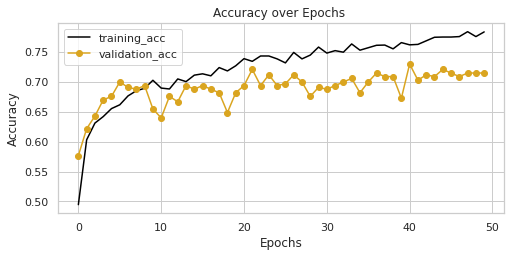

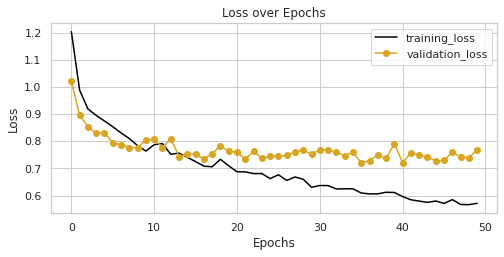

In [ ]:
plot_learning_curves(history_res151v2)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.5281 to fit



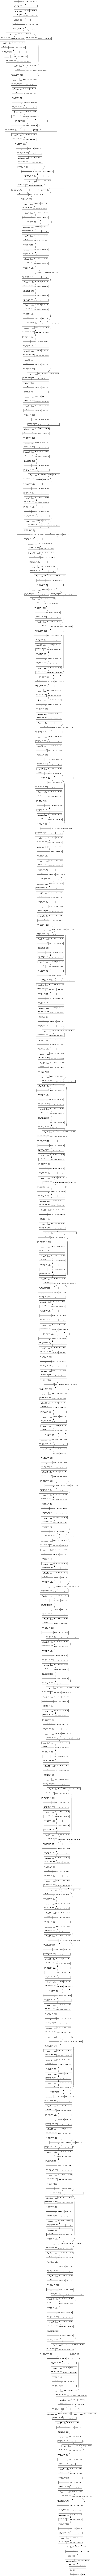

In [ ]:
# Plot model architecture
tf.keras.utils.plot_model(model_resnet152v2, show_shapes=True, show_layer_names=True)

#### #5. Transfer Learning with  *InceptionV* and *Data Augmentation*

This model was announced by the Google team in December 2015. V2 has two 3x3 convolution kernels
instead of a 5x5, while V3 will decompose more thoroughly. The core idea of V3 is to first use two 3x3
convolution kernels instead of 5x5 convolution kernels, and three 3x3 convolution kernels instead of
7x7 convolution kernels to reduce the amount of parameters and speed up calculations. V3 further
decomposes the nxn convolution kernel into 1xn and nx1 convolution kernels, while reducing the size
of the feature map and increasing the number of channels. 


In [ ]:
# Set InceptionV3 layers to frozen to keep the weights already made   
base_incv3 = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')

# Add layers to model
inputs_incv3 = base_incv3.input
incv3 = tf.keras.layers.Flatten()(base_incv3.output)
incv3 = tf.keras.layers.Dense(124, activation='relu')(incv3)
incv3 = tf.keras.layers.BatchNormalization()(incv3)
incv3 = tf.keras.layers.Dropout(0.25)(incv3)
outputs_incv3 = tf.keras.layers.Dense(4, activation='softmax')(incv3)

# Set the correct inputs and outputs to the model
model_incv3 = tf.keras.Model(inputs=inputs_incv3, outputs=outputs_incv3)

# Compile the model
model_incv3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Fit the model
history_incv3=model_incv3.fit(train_set_augmented,
              epochs=30,
              validation_data=val_set,
              verbose=2)

Epoch 1/30
21/21 - 47s - loss: 1.7327 - accuracy: 0.3899 - val_loss: 2.0960 - val_accuracy: 0.3994 - 47s/epoch - 2s/step
Epoch 2/30
21/21 - 37s - loss: 1.2703 - accuracy: 0.5252 - val_loss: 1.6644 - val_accuracy: 0.4985 - 37s/epoch - 2s/step
Epoch 3/30
21/21 - 37s - loss: 1.0538 - accuracy: 0.6038 - val_loss: 1.6803 - val_accuracy: 0.5556 - 37s/epoch - 2s/step
Epoch 4/30
21/21 - 37s - loss: 0.9621 - accuracy: 0.6344 - val_loss: 1.4797 - val_accuracy: 0.5495 - 37s/epoch - 2s/step
Epoch 5/30
21/21 - 37s - loss: 0.8633 - accuracy: 0.6787 - val_loss: 1.2413 - val_accuracy: 0.5886 - 37s/epoch - 2s/step
Epoch 6/30
21/21 - 37s - loss: 0.8117 - accuracy: 0.6940 - val_loss: 1.5092 - val_accuracy: 0.5886 - 37s/epoch - 2s/step
Epoch 7/30
21/21 - 37s - loss: 0.7377 - accuracy: 0.7193 - val_loss: 1.1849 - val_accuracy: 0.6937 - 37s/epoch - 2s/step
Epoch 8/30
21/21 - 37s - loss: 0.6742 - accuracy: 0.7361 - val_loss: 0.8478 - val_accuracy: 0.7267 - 37s/epoch - 2s/step
Epoch 9/30
21/21 - 37s - loss: 0

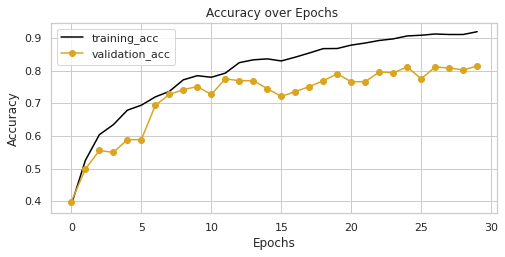

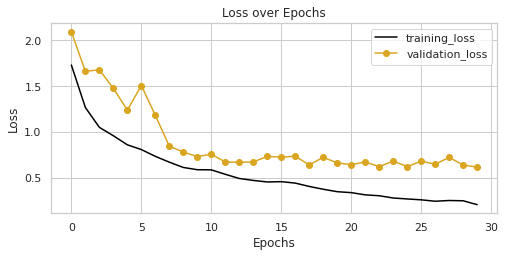

In [ ]:
plot_learning_curves(history_incv3)

### Bringing in Holdout Set

In [ ]:
# Make predictions with model
test_loss, test_acc = model_incv3.evaluate(test_set)
print('Testing accuracy:', test_acc)

11/11 [==============================] - 1s 69ms/step - loss: 0.7570 - accuracy: 0.7935
Testing accuracy: 0.7935103178024292


Confusion Matrix
Normalized Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.95      0.77      0.85        53
     Healthy       0.78      0.92      0.85       150
       Hispa       0.63      0.58      0.61        57
   LeafBlast       0.84      0.72      0.78        79

    accuracy                           0.79       339
   macro avg       0.80      0.75      0.77       339
weighted avg       0.80      0.79      0.79       339



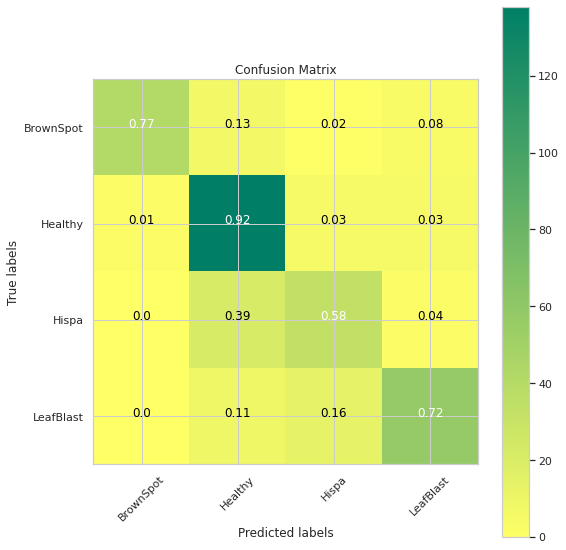

In [ ]:
#Plot the confusion matrix. Set Normalize = True

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix'):
  
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap='summer_r')
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')

#Print the Target names
target_names = []
for key in train_set.class_indices:
    target_names.append(key)

#Confution Matrix 
Y_pred = model_incv3.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion matrix of N = 339 images in test set. The confusion matrix provides an accurate view of how correctly the model predicts the classes or how the classes are misclassified. The values of the diagonal represented in green correspond to the number of correctly predicted image values for each class. The values of the matrix outside the diagonal represented in yellow correspond to incorrect predictions, where each cell relates the true class to the class predicted by the algorithm. 

In [ ]:
# Create data from the confusion matrix
df_conf_matrix = pd.DataFrame([['Predicted Brown Spot', 0.77, 0.13, 0.02, 0.08], ['Predicted Healthy', 0.01, 0.92, 0.03, 0.03], 
                               ['Predicted Hispa', 0.0, 0.39, 0.58, 0.04],['Predicted Leaf Blast', 0.0, 0.11, 0.16, 0.72]],
                  columns=['Class Names', 'Actual Brown Spot', 'Actual Healthy', 'Actual Hispa', 'Actual Leaf Blast'])
# Preview data
print(df_conf_matrix)

            Class Names  Actual Brown Spot  Actual Healthy  Actual Hispa  \
0  Predicted Brown Spot               0.77            0.13          0.02   
1     Predicted Healthy               0.01            0.92          0.03   
2       Predicted Hispa               0.00            0.39          0.58   
3  Predicted Leaf Blast               0.00            0.11          0.16   

   Actual Leaf Blast  
0               0.08  
1               0.03  
2               0.04  
3               0.72  


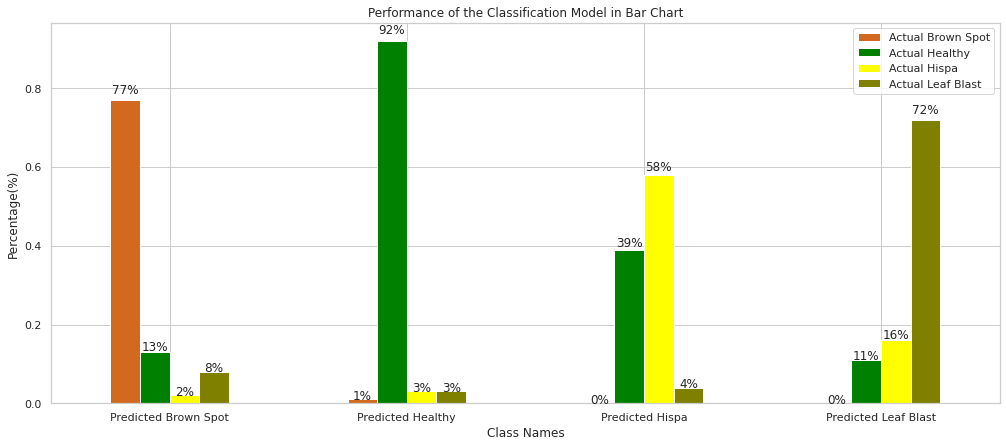

In [ ]:
# set the colors
colors = ['chocolate','green', 'yellow','olive']
# plot with annotations is probably easier
ax = df_conf_matrix.plot(kind='bar', x='Class Names', color=colors, figsize=(17, 7), rot=0, ylabel='Percentage(%)',
                         title="Performance of the Classification Model in Bar Chart")
# Add  loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')

### Conclusion

The advantages of an automated rice disease detection system can prove of much value to agricultural organizations and cultivators.
The performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning are evaluated systemically . The best model is the deep *InceptionV3* model trained with transfer learning, which yields an overall accuracy of 79% on the hold-out test set.

* *Brown Spot* - performed  predictions of true values (TP) at 77%. However, it has false alarms at 23% with other three classes.
* *Healthy* - performed almost perfect job at 92% with the true values (TP). It has  6% false alarms on *hispa* and *leaf blast*. Misclasification rate is 1% with *brown spot*.
* *Leaf Blast* - Performed correct prediction with 72% which  nearly same as *brown spot*(less 5%). It misclassified 26% with *healthy* and *hispa* leaves.
* *Hispa* - performing one of the worst according to our normalized confusion matrix. It did classify 39% of the leaves as a *healthy* ones which is bad for disease prevention. 

#### Limitations 

* Lack of enough samples and  unbalanced datasets. The under-representation of a particular category of 
rice disease results in a lack of necessary samples for the model to learn from, utilizing these sample 
in association with other mismatched categories result in unbalanced datasets that can bias the 
classification results.

* Low quality images, and color similarity make it difficult for models to identify features properly, and thus  not learn the necessary points for accurate classification.

## Recommendation

*Leaf Green* can be used to classify two common diseases*(brown spot, leaf blast)* along with *healthy* rice leaves. We recommend to use this product as early as possible to catch disease before it spreads to the rest of the rice plants.<p>
In terms of *hispa* disase model did struggle to classify it correctly. It may be due to the image quality. They may have a lot in common with regular healthy leaves so model classified them as a healthy ones. This class needs to be further improved with more and diverse image datasets.

### Future Consideration

The performance of proposed model can be further improved with 
large dataset of rice diseased images along with other common disease.<p>
Experimenting with a different algorithm and  adding some context to the data may also lead to some improvments.<p>
Based on the achieved results a mobile solution (application) can be developed
for farmers and agricultural organizations to detect rice leaf diseases at hand.
<p>
 Adding location data to the model would be helpful for users as some diseases are more common in certain climates. 